In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from loren_frank_data_processing import make_epochs_dataframe
from src.parameters import ANIMALS

epoch_info = make_epochs_dataframe(ANIMALS)

In [4]:
epoch_info.xs('con')

type environment  exposure
day epoch                             
1   1      sleep         nan       NaN
    2        run      TrackA       1.0
    3      sleep         nan       NaN
    4        run      TrackA       2.0
    5      sleep         nan       NaN
2   1      sleep         nan       NaN
    2        run      TrackA       3.0
    3      sleep         nan       NaN
    4        run      TrackA       4.0
    5      sleep         nan       NaN
3   1      sleep         nan       NaN
    2        run      TrackA       5.0
    3      sleep         nan       NaN
    4        run      TrackA       6.0
    5      sleep         nan       NaN
4   1      sleep         nan       NaN
    2        run      TrackB       1.0
    3      sleep         nan       NaN
    4        run      TrackB       2.0
    5      sleep         nan       NaN
    6        run      TrackA       7.0
    7      sleep         nan       NaN
5   1      sleep         nan       NaN
    2        run      TrackB       3.0
    3      sleep         nan       NaN
    4        run      TrackB       4.0
    5      sleep         nan       NaN
    6        run      TrackA       8.0
    7      sleep         nan       NaN
6   1      sleep         nan       NaN
    2        run      TrackB       5.0
    3      sleep         nan       NaN
    4        run      TrackB       6.0
    5      sleep         nan       NaN
    6        run      TrackA       9.0
    7      sleep         nan       NaN

In [5]:
from src.load_data import load_data

epoch_key = 'con', 3, 2

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Conley/conDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [20]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from src.analysis import get_is_classified, get_probability
from src.figure_utilities import TWO_COLUMN, ONE_COLUMN, PAGE_HEIGHT, save_figure
from src.parameters import PROBABILITY_THRESHOLD, STATE_COLORS

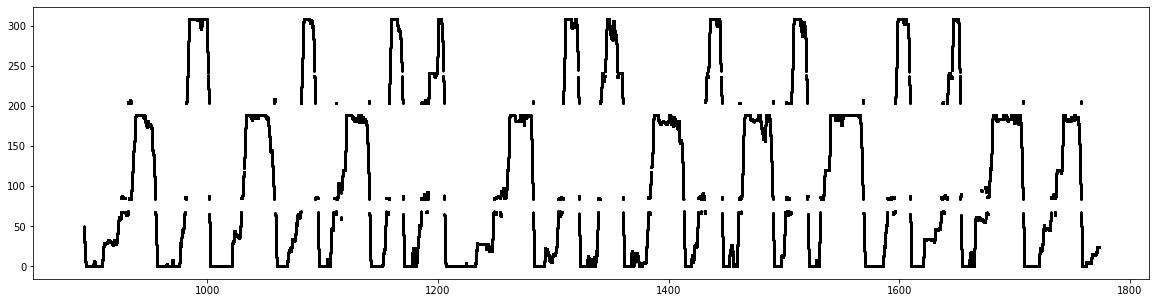

In [10]:
plt.figure(figsize=(20, 5))
plt.scatter(data['position_info'].index / np.timedelta64(1, 's'), data['position_info'].linear_position, s=1, color='black')

(0.0, 308.07342740922644)

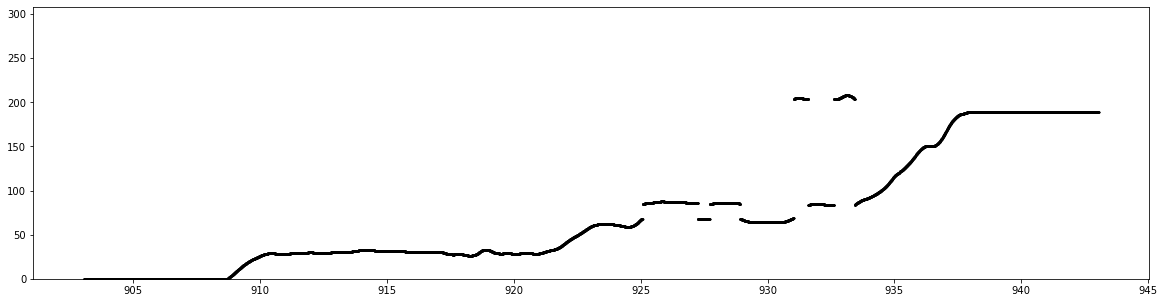

In [18]:
slice_ind = slice(5000, 25_000)

plt.figure(figsize=(20, 5))
plt.scatter(data['position_info'].iloc[slice_ind].index / np.timedelta64(1, 's'),
            data['position_info'].iloc[slice_ind].linear_position, s=1, color='black')
plt.ylim((0, data['position_info'].linear_position.max()))

In [44]:
from loren_frank_data_processing.multiunit import get_multiunit_dataframe

multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]

MILLISECONDS_TO_SECONDS = 1000


In [51]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs)

In [66]:
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)


training_start_time = data['position_info'].iloc[int(len(data['position_info']) * .2):].index[0]
is_training = data['position_info'].index > training_start_time
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

classifier.fit(
        position, data['multiunit'], is_training=is_training,
        track_graph=track_graph, center_well_id=center_well_id,
        edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)

ClusterlessClassifier(discrete_transition_diag=0.98, movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=3.0, replay_speed=1)

In [ ]:
results = classifier.predict(
    data["multiunit"].isel(time=~is_training),
    time=data["position_info"].iloc[~is_training].index,
)

In [75]:
results = (results.assign_coords(state=lambda ds: ds.state.to_index()
           .map(TRANSITION_TO_CATEGORY)))
results

<xarray.Dataset>
Dimensions:            (position: 98, state: 3, time: 87994)
Coordinates:
  * time               (time) timedelta64[ns] 00:14:53.055000 ... 00:17:49.04...
  * position           (position) float64 1.44 4.32 7.201 ... 300.7 303.7 306.6
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 0.189 0.1912 ... 1.0
    causal_posterior   (time, state, position) float64 0.002125 ... 0.0003003
    acausal_posterior  (time, state, position) float64 0.0004565 ... 0.0003003

In [398]:
def plot_run_slice(results, data, classifier, start_time, end_time,
                   cmap="bone_r",
                   figsize=(7, 9.72)):
    time_slice = slice(start_time, end_time)

    fig, axes = plt.subplots(
        5,
        1,
        sharex=False,
        constrained_layout=True,
        figsize=figsize,
        gridspec_kw={"height_ratios": [0.5, 0.5, 0.5, 3, 0.5]},
    )

    # axis 0
    lfp_start = start_time - pd.Timedelta(100, unit="ms")
    lfp_end = end_time + pd.Timedelta(100, unit="ms")
    lfps = data["lfps"].loc[lfp_start:lfp_end]
    tetrode_id = data['tetrode_info'].loc[
        (data['tetrode_info'].area == 'CA1') &
        (data['tetrode_info'].validripple == 1.0)].iloc[0].tetrode_id

    axes[0].plot(
        (lfps.index) / np.timedelta64(1, "s"),
        np.asarray(lfps.loc[:, tetrode_id]),
        color="black",
    )
    axes[0].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[0].axis("off")

    # axis 1
    multiunit_rate = data['multiunit_firing_rate'].loc[time_slice]
    axes[1].fill_between(multiunit_rate.index / np.timedelta64(1, 's'),
                         np.asarray(multiunit_rate).squeeze(),
                         color='black')
    axes[1].set_ylabel("Mulitunit Rate\n[spikes/s]")
    axes[1].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[1].set_xticks([])
    axes[1].set_ylim([0, int(np.max(np.asarray(multiunit_rate)))])
    axes[1].set_yticks([0, int(np.max(np.asarray(multiunit_rate)))])
    sns.despine(ax=axes[1], offset=5)
    axes[1].spines["bottom"].set_visible(False)

    # axis 2
    probability = results.sel(
        time=time_slice).acausal_posterior.sum(["position"])

    for state, prob in zip(results.state.values, probability.values.T):
        axes[2].plot(
            probability.time / np.timedelta64(1, "s"),
            prob,
            linewidth=1,
            color=STATE_COLORS[state],
            clip_on=False,
        )

    axes[2].set_ylim((0, 1))
    axes[2].set_yticks((0, 1))
    axes[2].set_ylabel("Prob.")
    axes[2].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[2].set_xticks([])
    sns.despine(ax=axes[2], offset=5)
    axes[2].spines["bottom"].set_visible(False)

    probability2 = get_probability(results.sel(time=time_slice))
    is_classified = get_is_classified(probability2, PROBABILITY_THRESHOLD)

    time = probability.time / np.timedelta64(1, "s")

    for state, is_class in zip(is_classified.state.values,
                               is_classified.values.T):
        if is_class.sum() > 0:
            axes[2].fill_between(
                time,
                is_class,
                where=is_class.astype(bool),
                alpha=0.25,
                color=STATE_COLORS[state],
            )

    # axis 3
    cmap = copy.copy(plt.cm.get_cmap(cmap))
    cmap.set_bad(color="lightgrey", alpha=1.0)
    (
        results.sel(time=time_slice).assign_coords(
            time=lambda ds: ds.time / np.timedelta64(1, "s")
        )
        .acausal_posterior.sum("state")
        .where(classifier.is_track_interior_)
        .plot(
            x="time",
            y="position",
            robust=True,
            add_colorbar=False,
            zorder=0,
            rasterized=True,
            cmap=cmap,
            ax=axes[3],
        )
    )
    axes[3].set_title("")

    position = data["position_info"].loc[time_slice, "linear_position"]
    max_position = int(
        np.ceil(data["position_info"].loc[:, "linear_position"].max()))
    axes[3].scatter(time, position, s=0.5,
                    color="magenta", clip_on=False)
    axes[3].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[3].set_ylabel("Position [cm]")
    axes[3].set_ylim((0, max_position))
    axes[3].set_yticks((0, max_position))
    axes[3].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[3].set_xticks([])
    axes[3].set_xlabel("")
    sns.despine(ax=axes[3], offset=5)
    axes[3].spines["bottom"].set_visible(False)
    
    # Axis 4
    speed = data["position_info"].loc[time_slice, "speed"]
    axes[4].fill_between(time, speed, color='lightgrey')
    max_speed = int(
        np.ceil(data["position_info"].loc[:, "speed"].max()))
    axes[4].set_xlabel("Time [ms]")
    axes[4].set_ylabel("Speed\n[cm/ms]")
    axes[4].set_ylim((0, max_speed))
    axes[4].set_xlim((start_time / np.timedelta64(1, 's'),
                  end_time / np.timedelta64(1, 's')))
    axes[4].set_yticks((0, max_speed))
    sns.despine(ax=axes[4], offset=5)

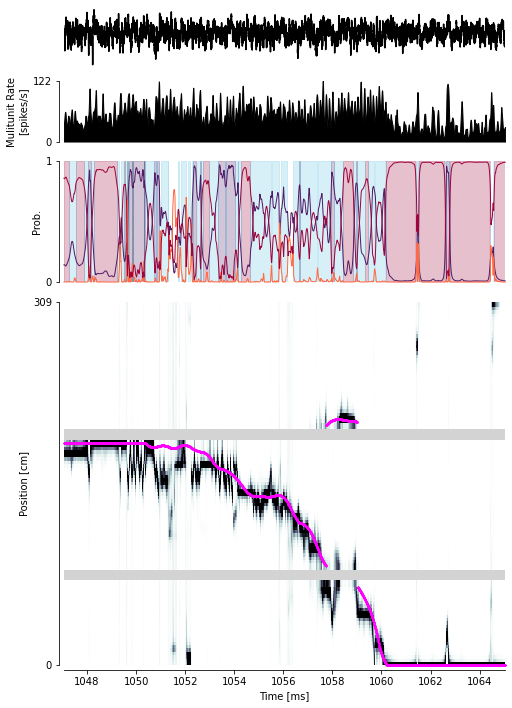

In [151]:
start_time, end_time = data['position_info'].iloc[~is_training].index[[77_000, -2000]]
plot_run_slice(results, data, classifier, start_time, end_time)

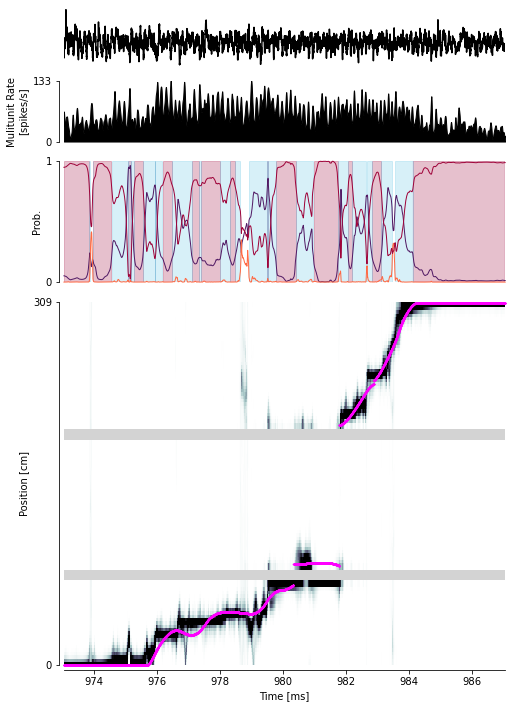

In [152]:
start_time, end_time = data['position_info'].iloc[~is_training].index[[40_000, 47_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

# Bon

In [154]:
from src.load_data import load_data

epoch_key = 'bon', 8, 4

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [ ]:
from sklearn.model_selection import KFold
import logging


logging.basicConfig(level='INFO', format='%(asctime)s %(message)s', datefmt='%d-%b-%y %H:%M:%S')

cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(
        cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index,
        )
    )

results = (xr.concat(results, dim="time")
           .assign_coords(state=lambda ds:
                          ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

09-Apr-21 14:23:02 Fitting Fold #1...
09-Apr-21 14:23:02 Fitting initial conditions...
09-Apr-21 14:23:02 Fitting state transition...
09-Apr-21 14:23:02 Fitting multiunits...
09-Apr-21 14:23:05 Predicting posterior...


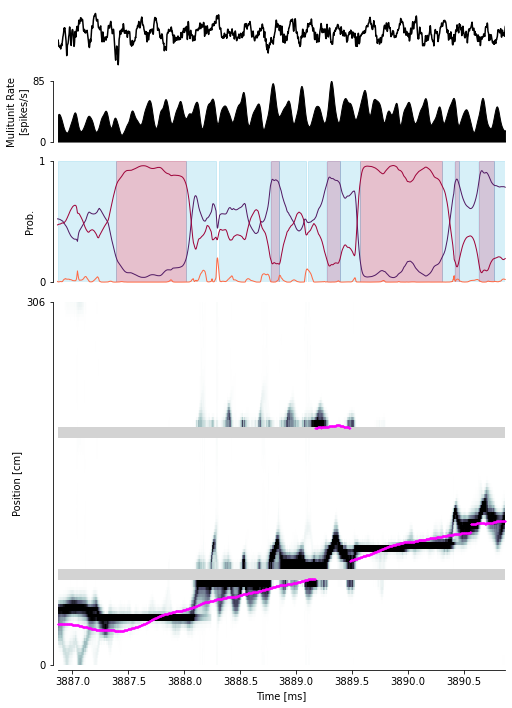

In [157]:
import pandas as pd

time = data["position_info"].index

start_time, end_time = time.min() + pd.Timedelta(240.85, unit='s'), time.min() + pd.Timedelta(244.85, unit='s')
plot_run_slice(results, data, classifier, start_time, end_time)

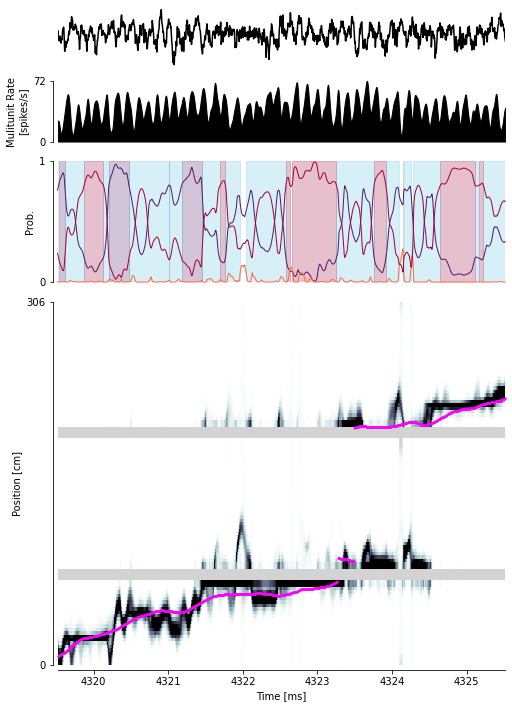

In [158]:
start_time, end_time = time.min() + pd.Timedelta(673.5, unit='s'), time.min() + pd.Timedelta(679.5, unit='s')
plot_run_slice(results, data, classifier, start_time, end_time)

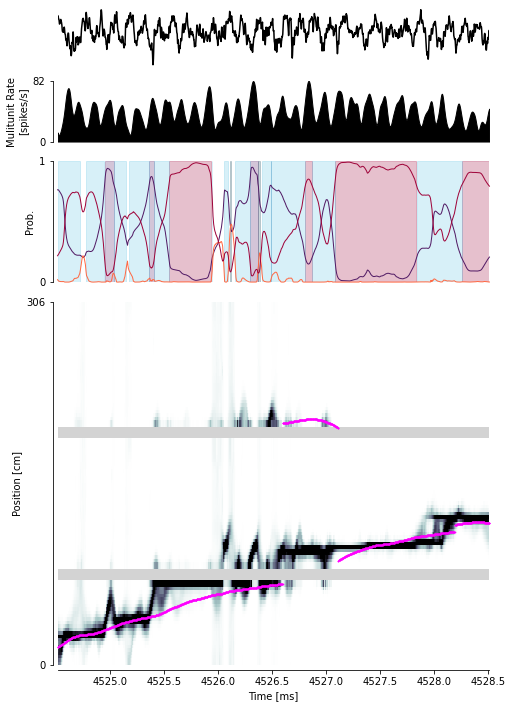

In [159]:
start_time, end_time = time.min() + pd.Timedelta(878.5, unit='s'), time.min() + pd.Timedelta(882.5, unit='s')
plot_run_slice(results, data, classifier, start_time, end_time)

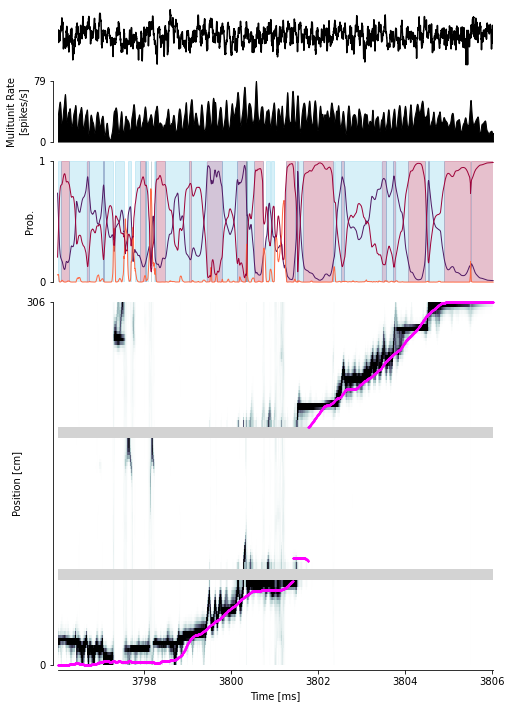

In [167]:
start_time, end_time = data['position_info'].index[[75_000, 80_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

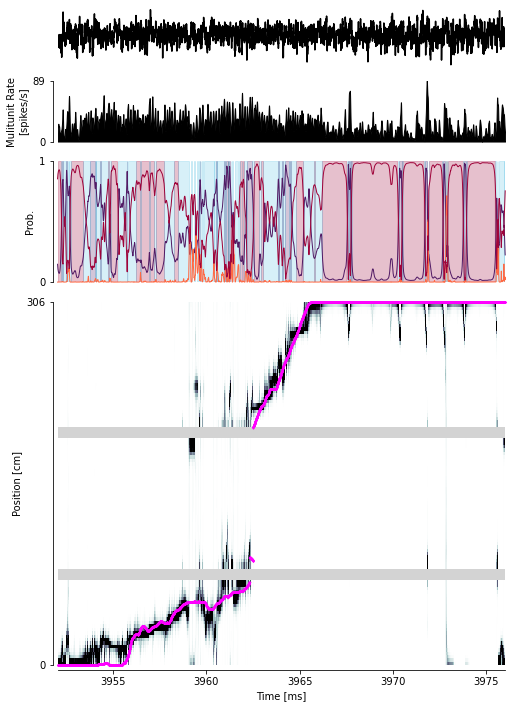

In [173]:
start_time, end_time = data['position_info'].index[[153_000, 165_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

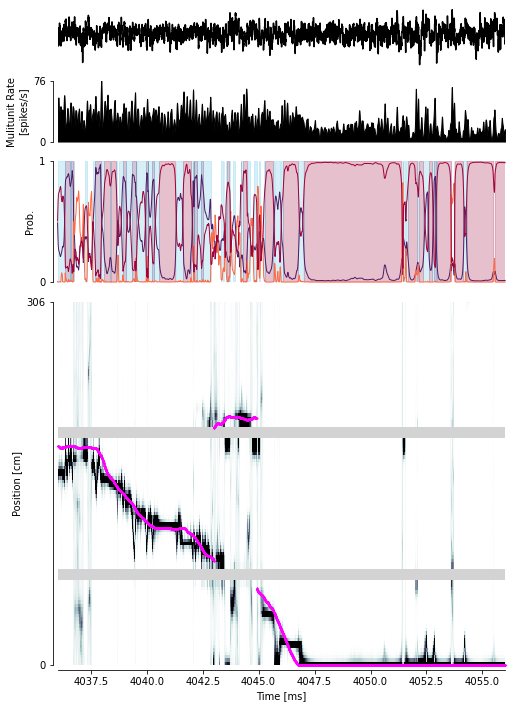

In [180]:
start_time, end_time = data['position_info'].index[[195_000, 205_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

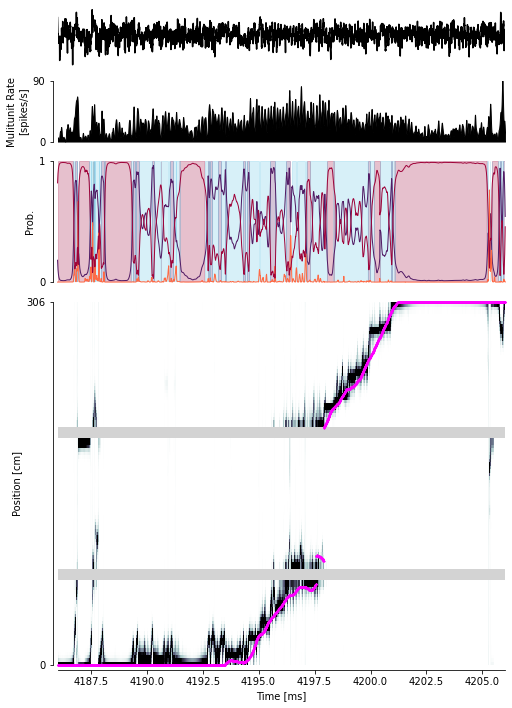

In [185]:
start_time, end_time = data['position_info'].index[[270_000, 280_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

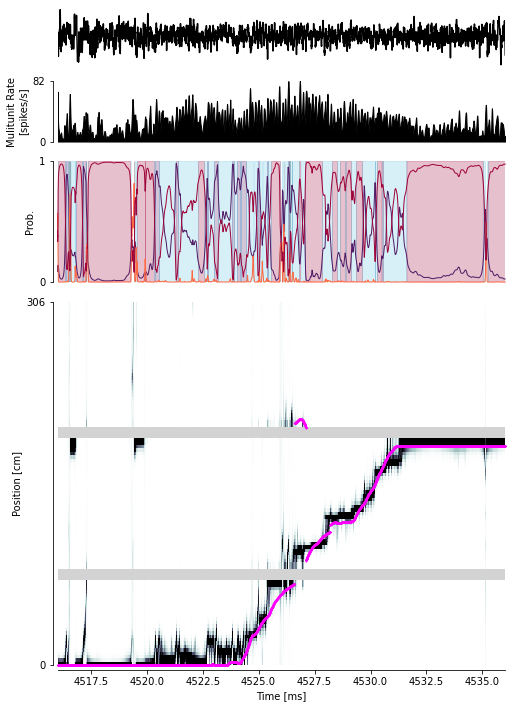

In [199]:
start_time, end_time = data['position_info'].index[[435_000, 445_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

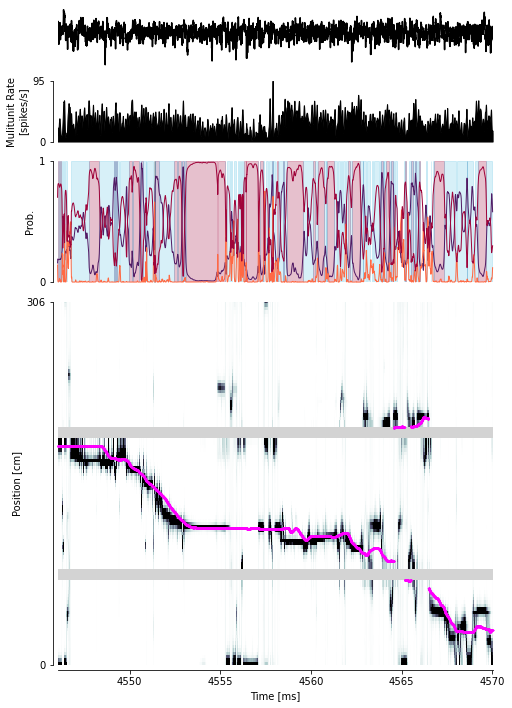

In [202]:
start_time, end_time = data['position_info'].index[[450_000, 461996]]
plot_run_slice(results, data, classifier, start_time, end_time)

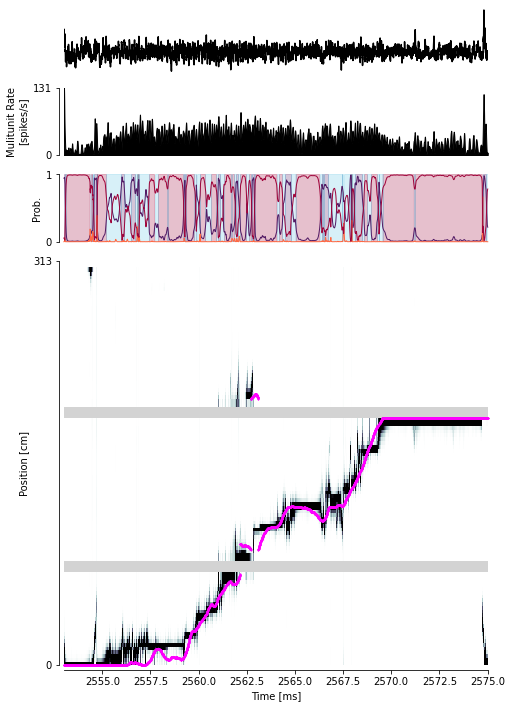

In [324]:
start_time, end_time = data['position_info'].index[[151_000, 162_000]]
plot_run_slice(results, data, classifier, start_time, end_time)

### bon, 5, 2

In [ ]:
epoch_key = 'bon', 5, 2

data = load_data(epoch_key)

logging.basicConfig(level='INFO', format='%(asctime)s %(message)s', datefmt='%d-%b-%y %H:%M:%S')

cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(
        cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index,
        )
    )

results = (xr.concat(results, dim="time")
           .assign_coords(state=lambda ds:
                          ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

13-Apr-21 12:06:50 Loading position info...
13-Apr-21 12:07:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
13-Apr-21 12:07:43 No DIO file found, using distance from well to segment trials
13-Apr-21 12:07:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
13-Apr-21 12:07:43 No DIO file found, inferring correct inbound/outbound from task rules
13-Apr-21 12:08:08 Loading spikes...
13-Apr-21 12:08:20 Loading multiunit...
13-Apr-21 12:08:23 Finding ripple times...
13-Apr-21 12:10:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
13-Apr-21 12:10:43 No DIO file found, using distance from well to segment trials
13-Apr-21 12:10:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO05.mat
13-Apr-21 12:10:44 No DIO file found, inferring correct inbound/outbound from task rules
13-Apr-21 12:11:14 Fitting Fold #1...
13-Apr-21 12:1

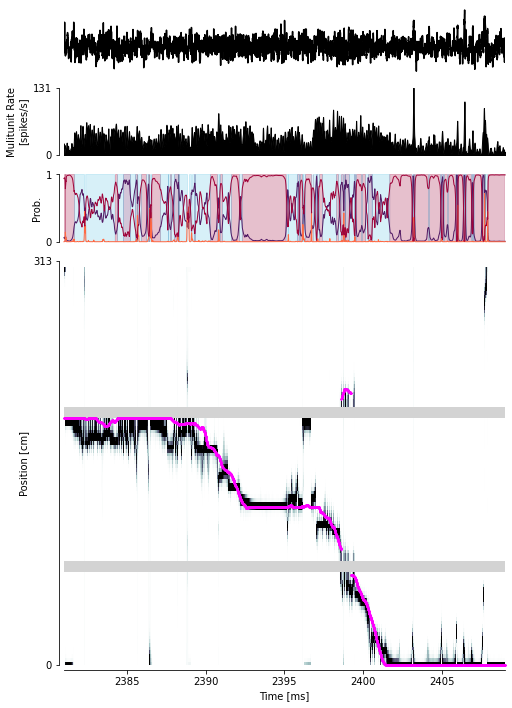

In [377]:
start_time, end_time = data['position_info'].index[[65_000, 79_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

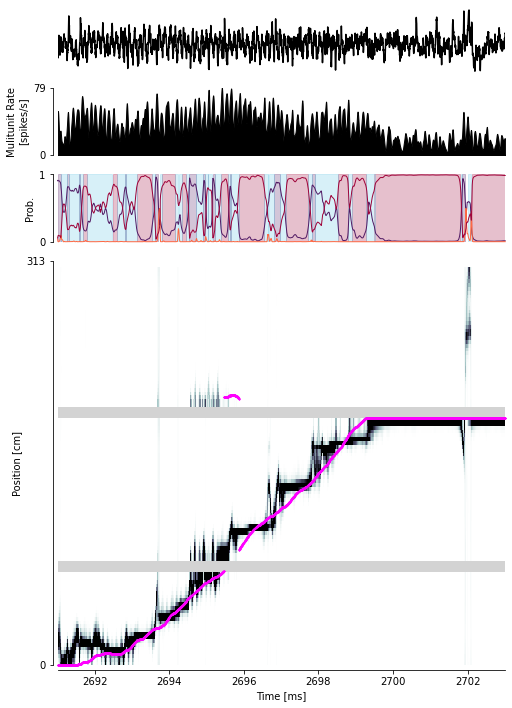

In [378]:
start_time, end_time = data['position_info'].index[[220_000, 226_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

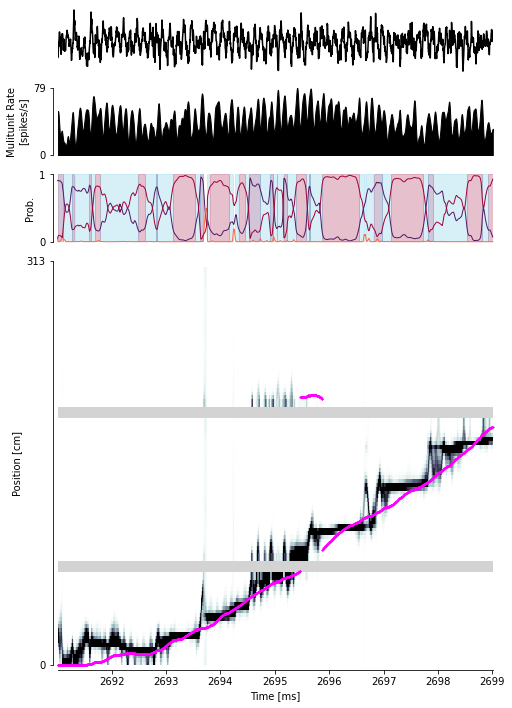

In [380]:
start_time, end_time = data['position_info'].index[[220_000, 224_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

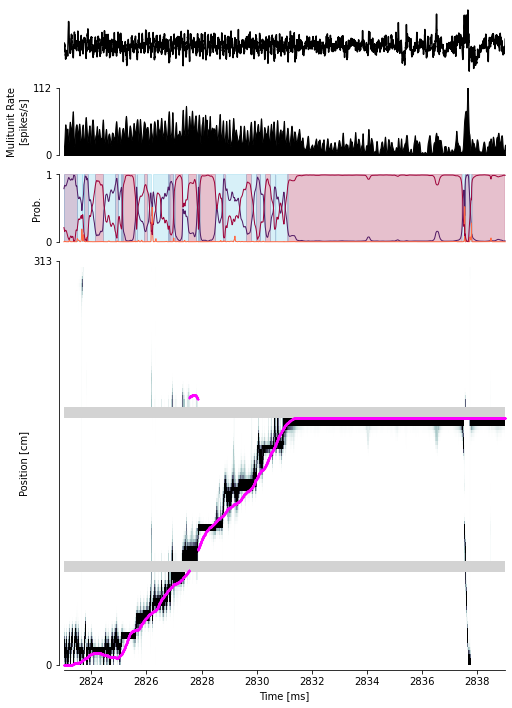

In [349]:
start_time, end_time = data['position_info'].index[[286_000, 294_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

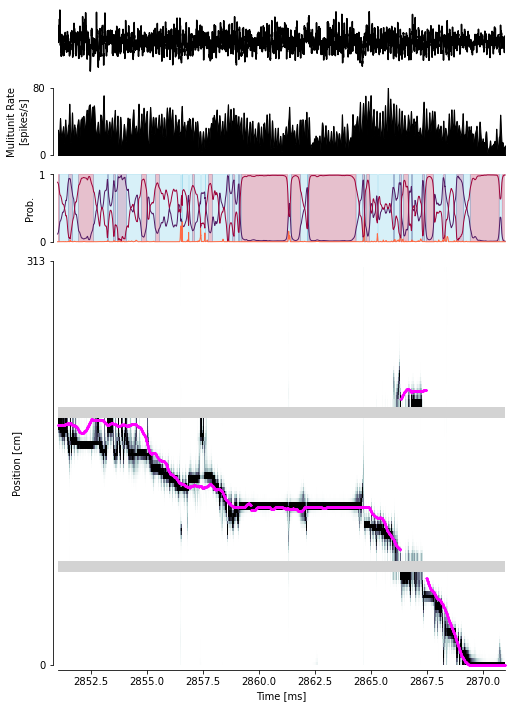

In [351]:
start_time, end_time = data['position_info'].index[[300_000, 310_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

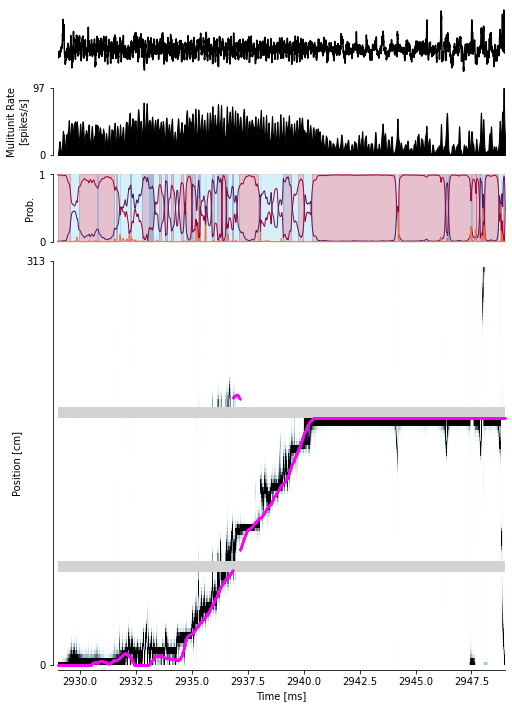

In [392]:
start_time, end_time = data['position_info'].index[[339_000, 349_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

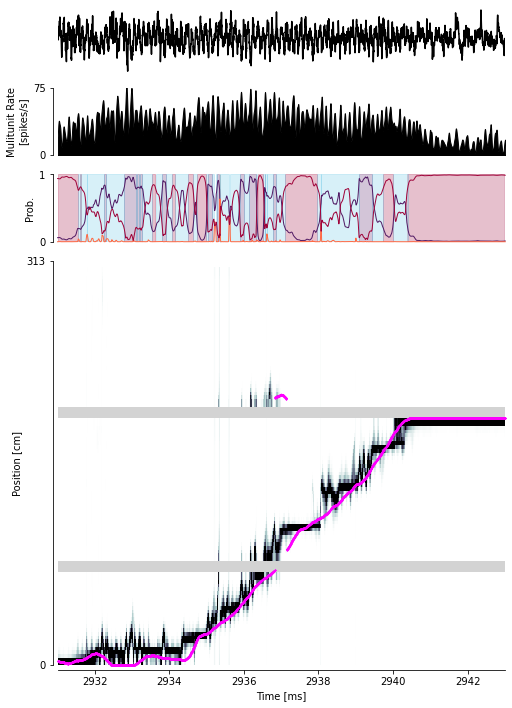

In [393]:
start_time, end_time = data['position_info'].index[[340_000, 346_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

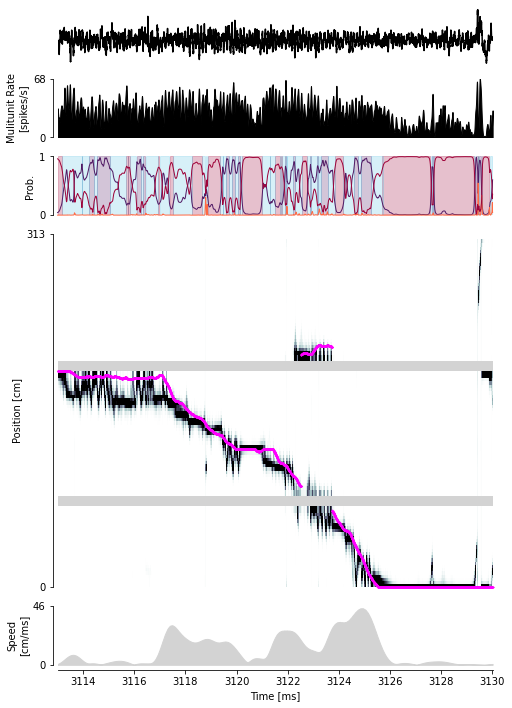

In [399]:
start_time, end_time = data['position_info'].index[[431_000, 439_500]]

plot_run_slice(results, data, classifier, start_time, end_time)

# Frank

In [210]:
from src.load_data import load_data

epoch_key = 'fra', 6, 4

data = load_data(epoch_key)

12-Apr-21 13:56:24 Loading position info...
12-Apr-21 13:57:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
12-Apr-21 13:57:15 No DIO file found, using distance from well to segment trials
12-Apr-21 13:57:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
12-Apr-21 13:57:16 No DIO file found, inferring correct inbound/outbound from task rules
12-Apr-21 13:57:31 Loading spikes...
12-Apr-21 13:57:45 Loading multiunit...
12-Apr-21 13:57:48 Finding ripple times...
12-Apr-21 14:00:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
12-Apr-21 14:00:07 No DIO file found, using distance from well to segment trials
12-Apr-21 14:00:08 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
12-Apr-21 14:00:08 No DIO file found, inferring correct inbound/outbound from task rules


In [ ]:
from sklearn.model_selection import KFold
import logging


logging.basicConfig(level='INFO', format='%(asctime)s %(message)s', datefmt='%d-%b-%y %H:%M:%S')

cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(
        cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index,
        )
    )

results = (xr.concat(results, dim="time")
           .assign_coords(state=lambda ds:
                          ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

12-Apr-21 14:00:33 Fitting Fold #1...
12-Apr-21 14:00:34 Fitting initial conditions...
12-Apr-21 14:00:34 Fitting state transition...
12-Apr-21 14:00:34 Fitting multiunits...
12-Apr-21 14:00:36 Predicting posterior...
12-Apr-21 15:03:56 Fitting Fold #2...
12-Apr-21 15:03:56 Fitting initial conditions...
12-Apr-21 15:03:56 Fitting state transition...
12-Apr-21 15:03:57 Fitting multiunits...
12-Apr-21 15:03:59 Predicting posterior...


In [212]:
results

<xarray.Dataset>
Dimensions:            (position: 98, state: 3, time: 462996)
Coordinates:
  * time               (time) timedelta64[ns] 01:18:48.014400 ... 01:34:14.00...
  * position           (position) float64 1.44 4.32 7.201 ... 300.7 303.7 306.6
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 1.0 0.9898 ... 0.8612
    causal_posterior   (time, state, position) float64 0.005035 ... 0.0002161
    acausal_posterior  (time, state, position) float64 0.003394 ... 0.0002161

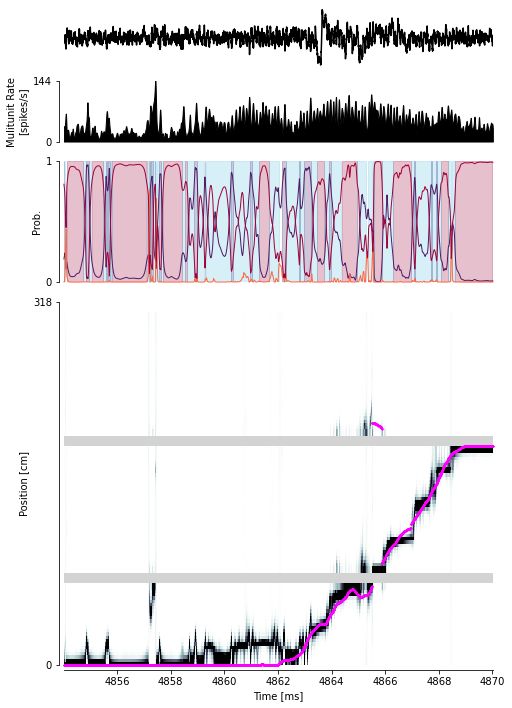

In [279]:
start_time, end_time = data['position_info'].index[[63_000, 71_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

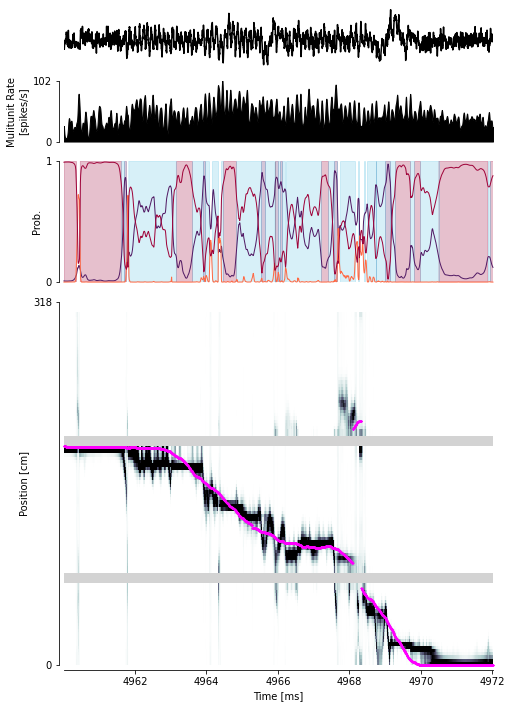

In [281]:
start_time, end_time = data['position_info'].index[[116_000, 122_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

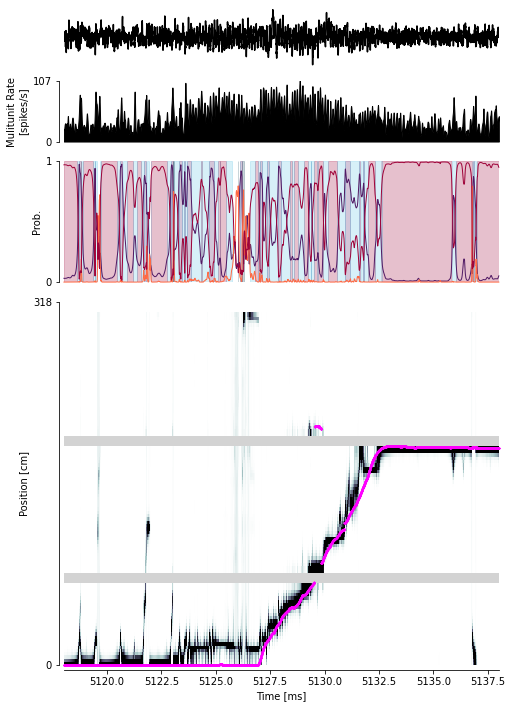

In [282]:
start_time, end_time = data['position_info'].index[[195_000, 205_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

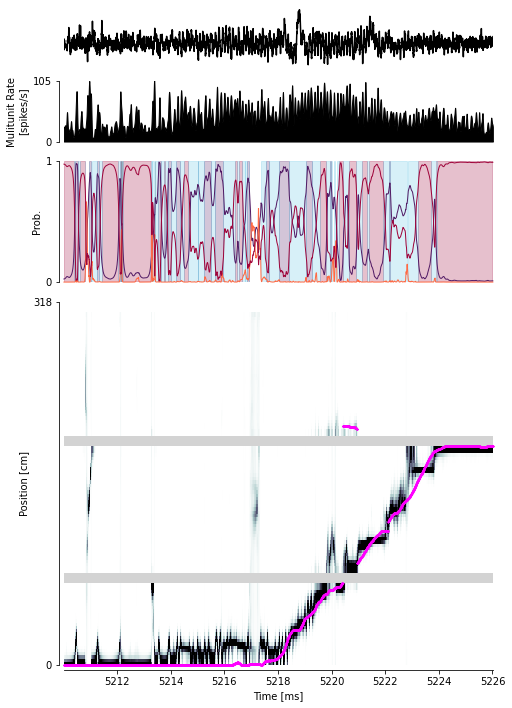

In [283]:
start_time, end_time = data['position_info'].index[[241_000, 249_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

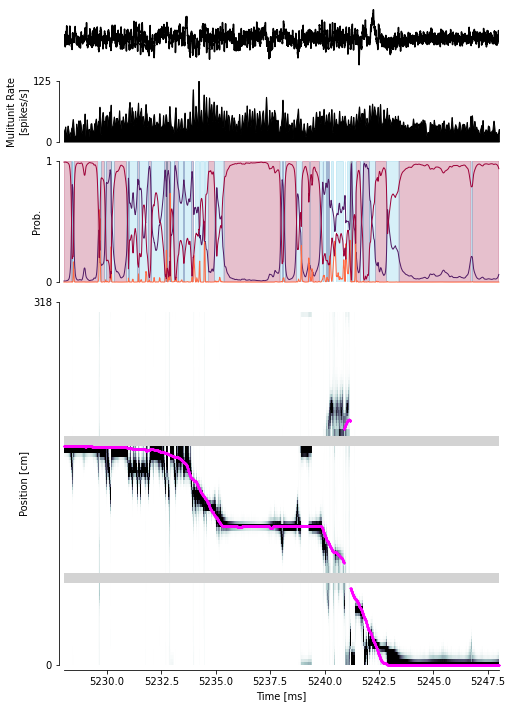

In [284]:
start_time, end_time = data['position_info'].index[[250_000, 260_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

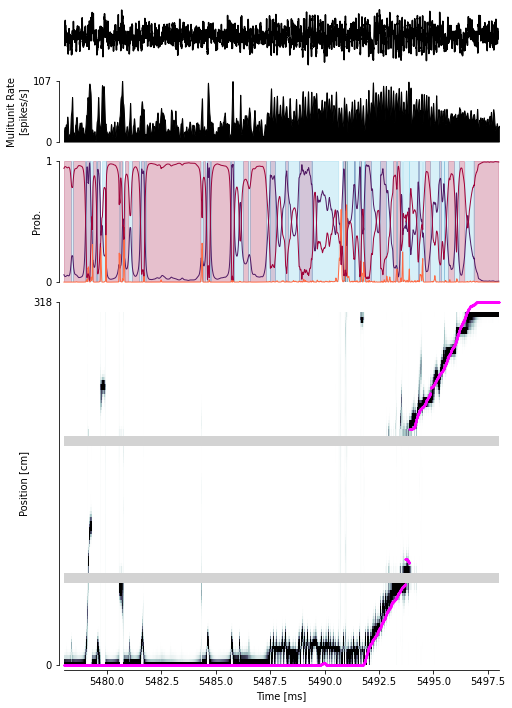

In [307]:
start_time, end_time = data['position_info'].index[[375_000, 385_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

In [311]:
data['ripple_times'].loc[((data['ripple_times'].start_time > start_time) & (data['ripple_times'].end_time < end_time))]

,start_time,end_time,duration
ripple_number,,,
195,0 days 01:31:19.084454073,0 days 01:31:19.191120748,0.106667
196,0 days 01:31:19.193787415,0 days 01:31:19.271787420,0.078000
197,0 days 01:31:19.565787441,0 days 01:31:19.619120778,0.053333
198,0 days 01:31:19.730454120,0 days 01:31:19.886454131,0.156000
199,0 days 01:31:20.605787516,0 days 01:31:20.758454194,0.152667
200,0 days 01:31:24.651787807,0 days 01:31:24.696454477,0.044667
201,0 days 01:31:26.106454579,0 days 01:31:26.149787915,0.043333
202,0 days 01:31:29.714454839,0 days 01:31:29.755788175,0.041333


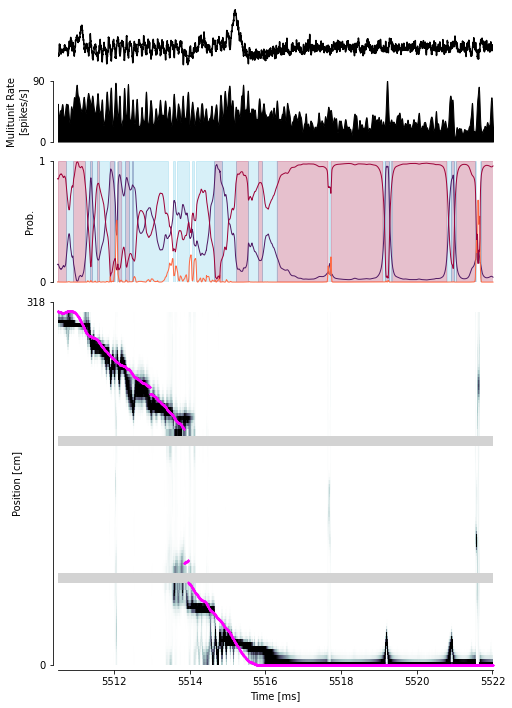

In [303]:
start_time, end_time = data['position_info'].index[[391_250, 397_000]]

plot_run_slice(results, data, classifier, start_time, end_time)